In [47]:
import xlsxwriter    
import pytesseract
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram, equalize_hist
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv,hsv2rgb,rgba2rgb
from skimage.transform import (hough_line, hough_line_peaks)
import skimage.exposure
# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 
    

def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12,8))
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X,Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()
    
def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    
    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq)+1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq)+1))
    
    show_3d_image(img_in_freq, 'Original Image')
    show_3d_image(filtered_img_in_freq, 'Filtered Image')


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


In [48]:
# !pip install pytesseract
# !conda install pandas



import cv2 
import pytesseract
import utlis


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def _imshow(img):
    cv2.imshow('image', img)
    plt.show()
    # specify a wait key from keyboard
    k = cv2.waitKey(0) & 0xFF

    if k == 27: #esc in keyboard
        cv2.destroyAllWindows() #close the window   

    elif k == ord('s'): #if order is s save the image
        cv2.imwrite('lena_copy.png', img) #write image in your pc     
        cv2.destroyAllWindows() # close the window 



def _scannar(img):
    heightImg = img.shape[1]
    widthImg  = img.shape[0]
    imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
    imgBlur = img

    imgsobel = sobel(imgBlur)
    imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
    kernel = np.ones((3, 3))
    imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
    imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



    ## FIND ALL COUNTOURS
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
    imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


    # FIND THE BIGGEST COUNTOUR
    biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

    if biggest.size != 0:
        biggest=utlis.reorder(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
        imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

        #REMOVE 20 PIXELS FORM EACH SIDE
        imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]

        # APPLY ADAPTIVE THRESHOLD
        # imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
        # imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
        imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

    thres = 100
    img_bin = np.copy(imgAdaptiveThre)
    img_bin[imgAdaptiveThre < thres] = 0
    img_bin[imgAdaptiveThre >= thres] = 255
    img = img_bin
    _imshow(img)
    show_images([img_bin])
    return img

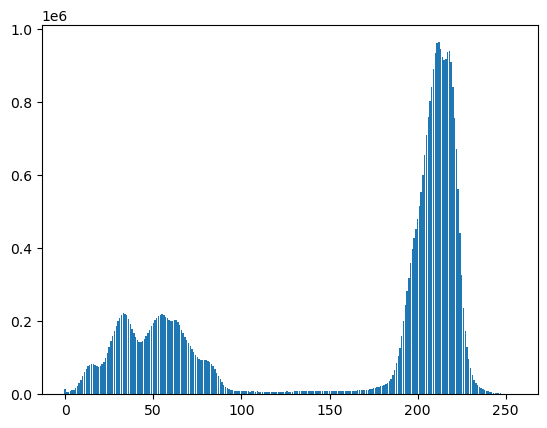

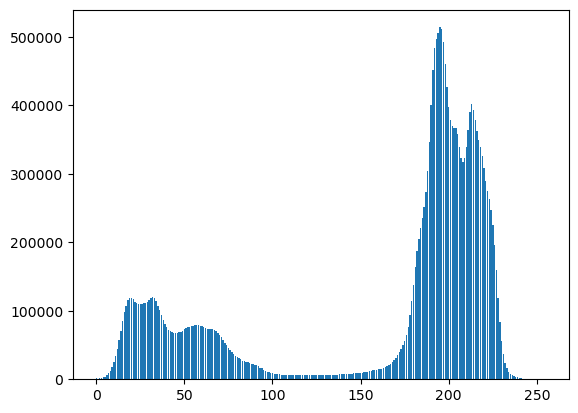

In [50]:
## Read img wit GRAY scale 
file1 = r"1.jpg"
file2 = r"24.jpg"

img1 = cv2.imread(file1) # 0 for gray scale , 1 for color , -1 for alpha channel
img2 = cv2.imread(file2) # 0 for gray scale , 1 for color , -1 for alpha channel

img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# print(img)
showHist(img1)
io.show()
showHist(img2)
io.show()
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR'

# plt.show()
# _imshow(img)

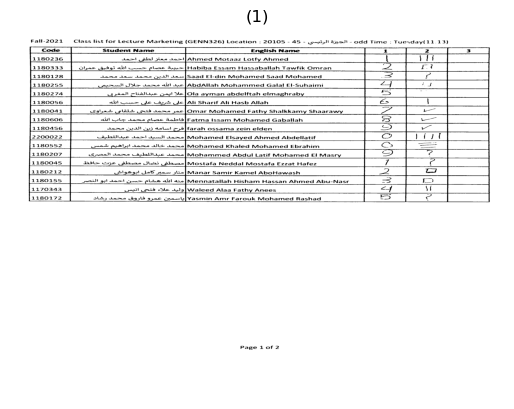

In [51]:
scan = input("Do you want to scan the image?")
if scan  == "y":
    img = _scannar(img)

In [52]:
### Binary img
## method 1
thresh,img_bin = cv2.threshold(img,50,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

## method 2
# img_bin = np.copy(img)
# thres = 200
# img_bin[img < thres] = 1
# img_bin[img >= thres] = 0
# plotting = plt.imshow(img_bin,cmap='gray')
# plt.show()

## Negative transform
img_bin = 255 - img_bin
_imshow(img_bin)


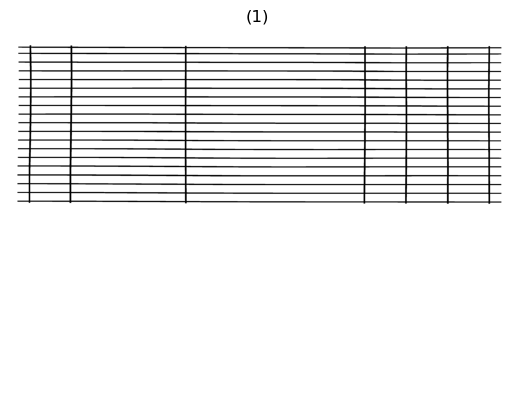

In [53]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//200
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (4, 4))

# Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=4)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=5)


# Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=15)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=25)


# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# cv2.imwrite("/Users/YOURPATH/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)


#Plotting the generated image
show_images([img_vh])
_imshow(img_vh)
# show_images([])


After having the tabular structure we use the findContours function to detect the contours. This helps us to retrieve the exact coordinates of each box.

number of contours: 110


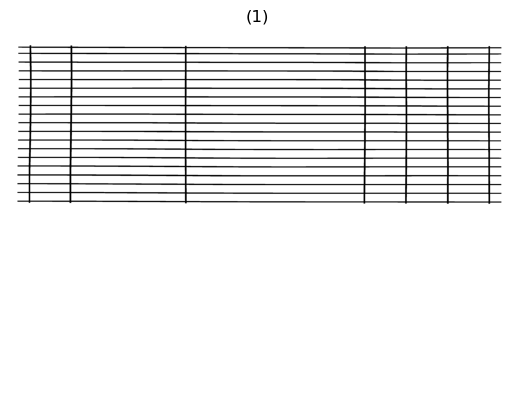

In [54]:
# Detect contours for following box detection
rgb_img = cv2.cvtColor(img_vh, cv2.COLOR_GRAY2RGB)
imgray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(f"number of contours: {len(contours)}")
# print(contours[0])
img_vhcopy = np.copy(imgray)

cv2.drawContours(imgray,contours,0,(0,0,255),1)

show_images([img_vhcopy])

# cv2.imshow('Image GRAY', imgray)

# print(hierarchy)
# img1 = img_vh[-1:-1,-1:1]
# plotting = plt.imshow(img1,cmap='gray')
# plt.show()

The following function is necessary to get a sequence of the contours and to sort them from top-to-bottom (https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/).

In [55]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")


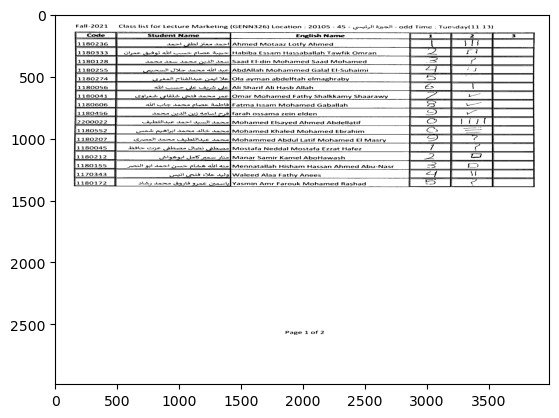

In [56]:

 #Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
 #Get mean of heights
mean = np.mean(heights)

 #Create list box to store all boxes in  
box = []
 # Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap="gray")
plt.show()


In [57]:


# #Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
# print(column)
# print(row)


In [58]:

 #calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()


In [59]:


#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

# print(finalboxes)


In [60]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=""
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

PermissionError: [WinError 5] Access is denied

In [ ]:

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel('output.xlsx')


ValueError: cannot reshape array of size 0 into shape (17,5)